In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score


In [2]:
%matplotlib inline

## Data Processing

To process the data, we start by seperating out the target variable (DEP_DEL15) from the data. Furthermore, we factorise the two categorical variables, DEP_TIME_BLK and PREVIOUS_AIRPORT in order to convert them to numerical variables. From the EDA, we know that there are no missing values so no imputation is required.

In [3]:
data = pd.read_csv("jfk_flight_data.csv")

X = data.drop(columns=['DEP_DEL15'])
X["DEP_TIME_BLK"],DEP_TIME_BLKS = pd.factorize(X["DEP_TIME_BLK"])   
X["CARRIER_NAME"], CARRIER_NAMES = pd.factorize(X["CARRIER_NAME"])
X["PREVIOUS_AIRPORT"], PREVIOUS_AIRPORTS = pd.factorize(X["PREVIOUS_AIRPORT"]) 

y = data['DEP_DEL15']

In [10]:
X.tail()

,MONTH,DAY_OF_WEEK,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRLINE,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS,PLANE_AGE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
125104,12,6,12,2,6,18,44,6,26721,406,1204766,0.000348,0.000107,17,64,0.0,0.0,0.0,35,4.7
125105,12,6,12,3,6,18,76,5,23119,1573,1212846,0.000000,0.000094,6,21,0.0,0.0,0.0,35,4.7
125106,12,6,12,2,7,18,76,5,23119,1573,1212846,0.000000,0.000094,5,44,0.0,0.0,0.0,35,4.7
125107,12,6,0,5,7,22,110,0,81498,2780,12460183,0.000144,0.000149,17,30,0.0,0.0,0.0,35,4.7
125108,12,6,18,2,7,5,100,3,25034,3454,3190369,0.000160,0.000127,12,20,0.0,0.0,0.0,35,4.7


In [33]:

def vis_features(data):
    num_features = sum(data[column].dtype in ['int64', 'float64'] for column in data.columns)

    nrows = (num_features + 1) // 2  # 2 columns per row
    ncols = 2


    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 40))

    feature_counter = 0
    for column in data.columns:
        if data[column].dtype in ['int64', 'float64']:
            ax = axes[feature_counter // 2, feature_counter % 2]
            sns.histplot(data=data, x=column, kde=True, ax=ax)
            ax.set_title(f'Distribution of {column}')
            ax.tick_params(axis='x', labelrotation=45)  # Rotate x-axis labels
            feature_counter += 1

    plt.tight_layout()
    plt.show()

We have chosen to use a 80%/20% split for the train and test data as it provides a reasonable balance between having enough data for the model to learn from and having a substantial portion reserved for evaluating the model's performance.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Class Imbalance Problem

From the plot below, we can see that the data set is imbalanced 81.1% (0) to 18.9% (1). The presence of a strong imbalance in the distribution of the target variable can lead to problems in classification. For example, models can become biased towards the majority class leading to poor performance in predicting the minority class.

In this section, we explored different resampling techniques for dealing with class imbalance. [1]

In [5]:
def imbalance(item):
    case_count = item.value_counts()
    print('Legend:')
    print(case_count)
    
    plt.figure(figsize=(6, 6))
    plt.pie(case_count, labels=['Not Delayed (0)', 'Delayed (1)'], autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
    plt.title('Label Distribution', fontsize=16)
    plt.show()
    
    

Legend:
0    101446
1     23663
Name: DEP_DEL15, dtype: int64


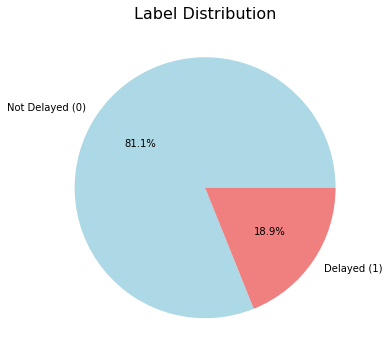

In [6]:
imbalance(y)

We should see that after using a resampling technique, the class imbalance should improve while the distribution of the other variables should remain very similar to that of the imbalanced data,

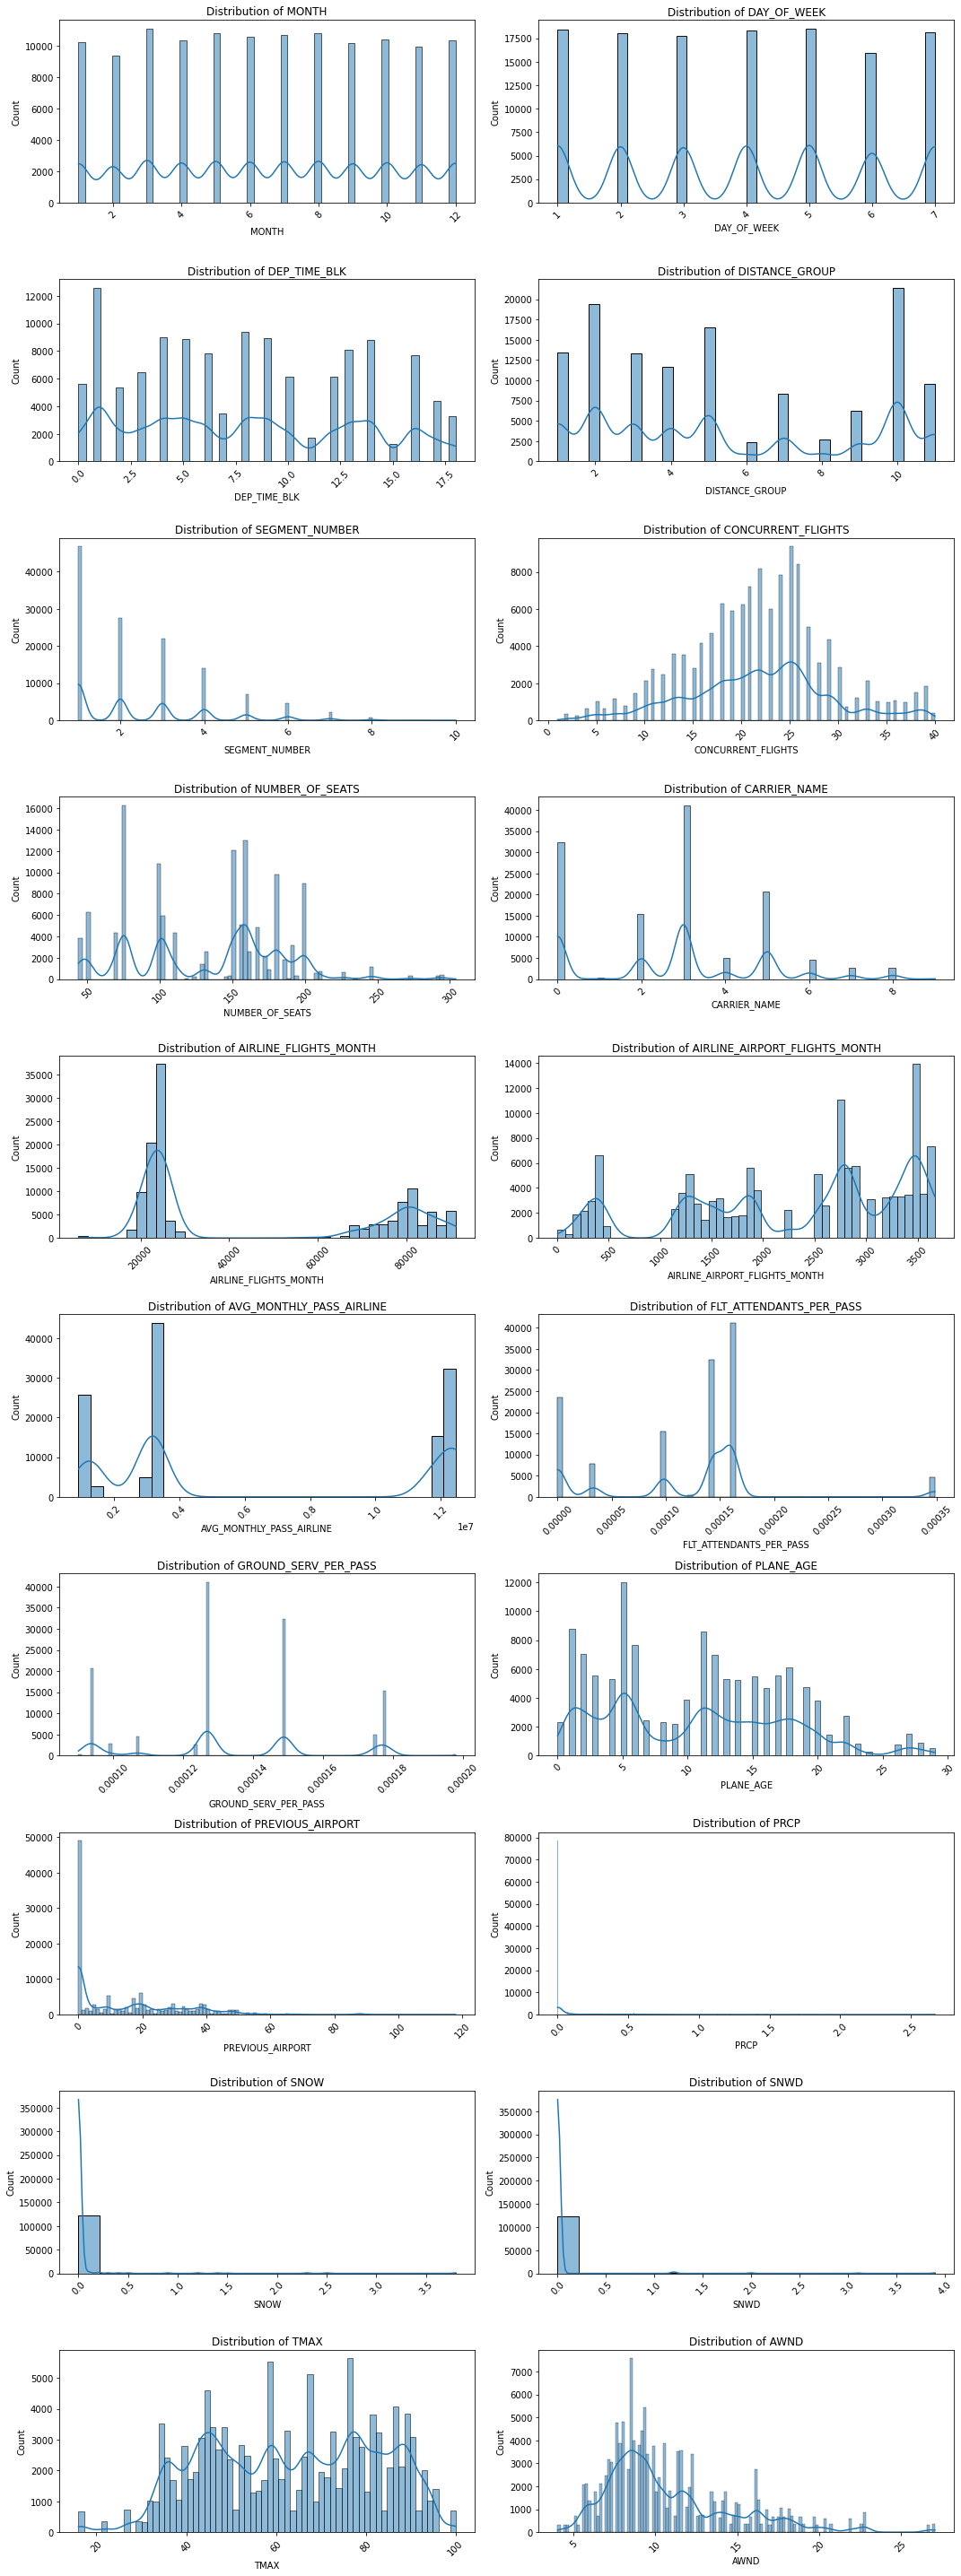

In [15]:
vis_features(X)

## Oversampling Techniques

### ROSE (Random Oversampling Examples) 
ROSE oversamples the minority class by randomly selecting examples from the minority class and duplicating them.

In [24]:
from imblearn.over_sampling import RandomOverSampler
rose = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_rose, y_rose = rose.fit_resample(X, y)


Legend:
0    101446
1    101446
Name: DEP_DEL15, dtype: int64


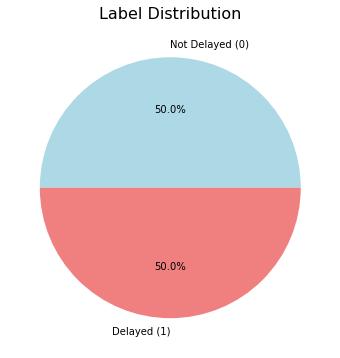

In [37]:
imbalance(y_rose)

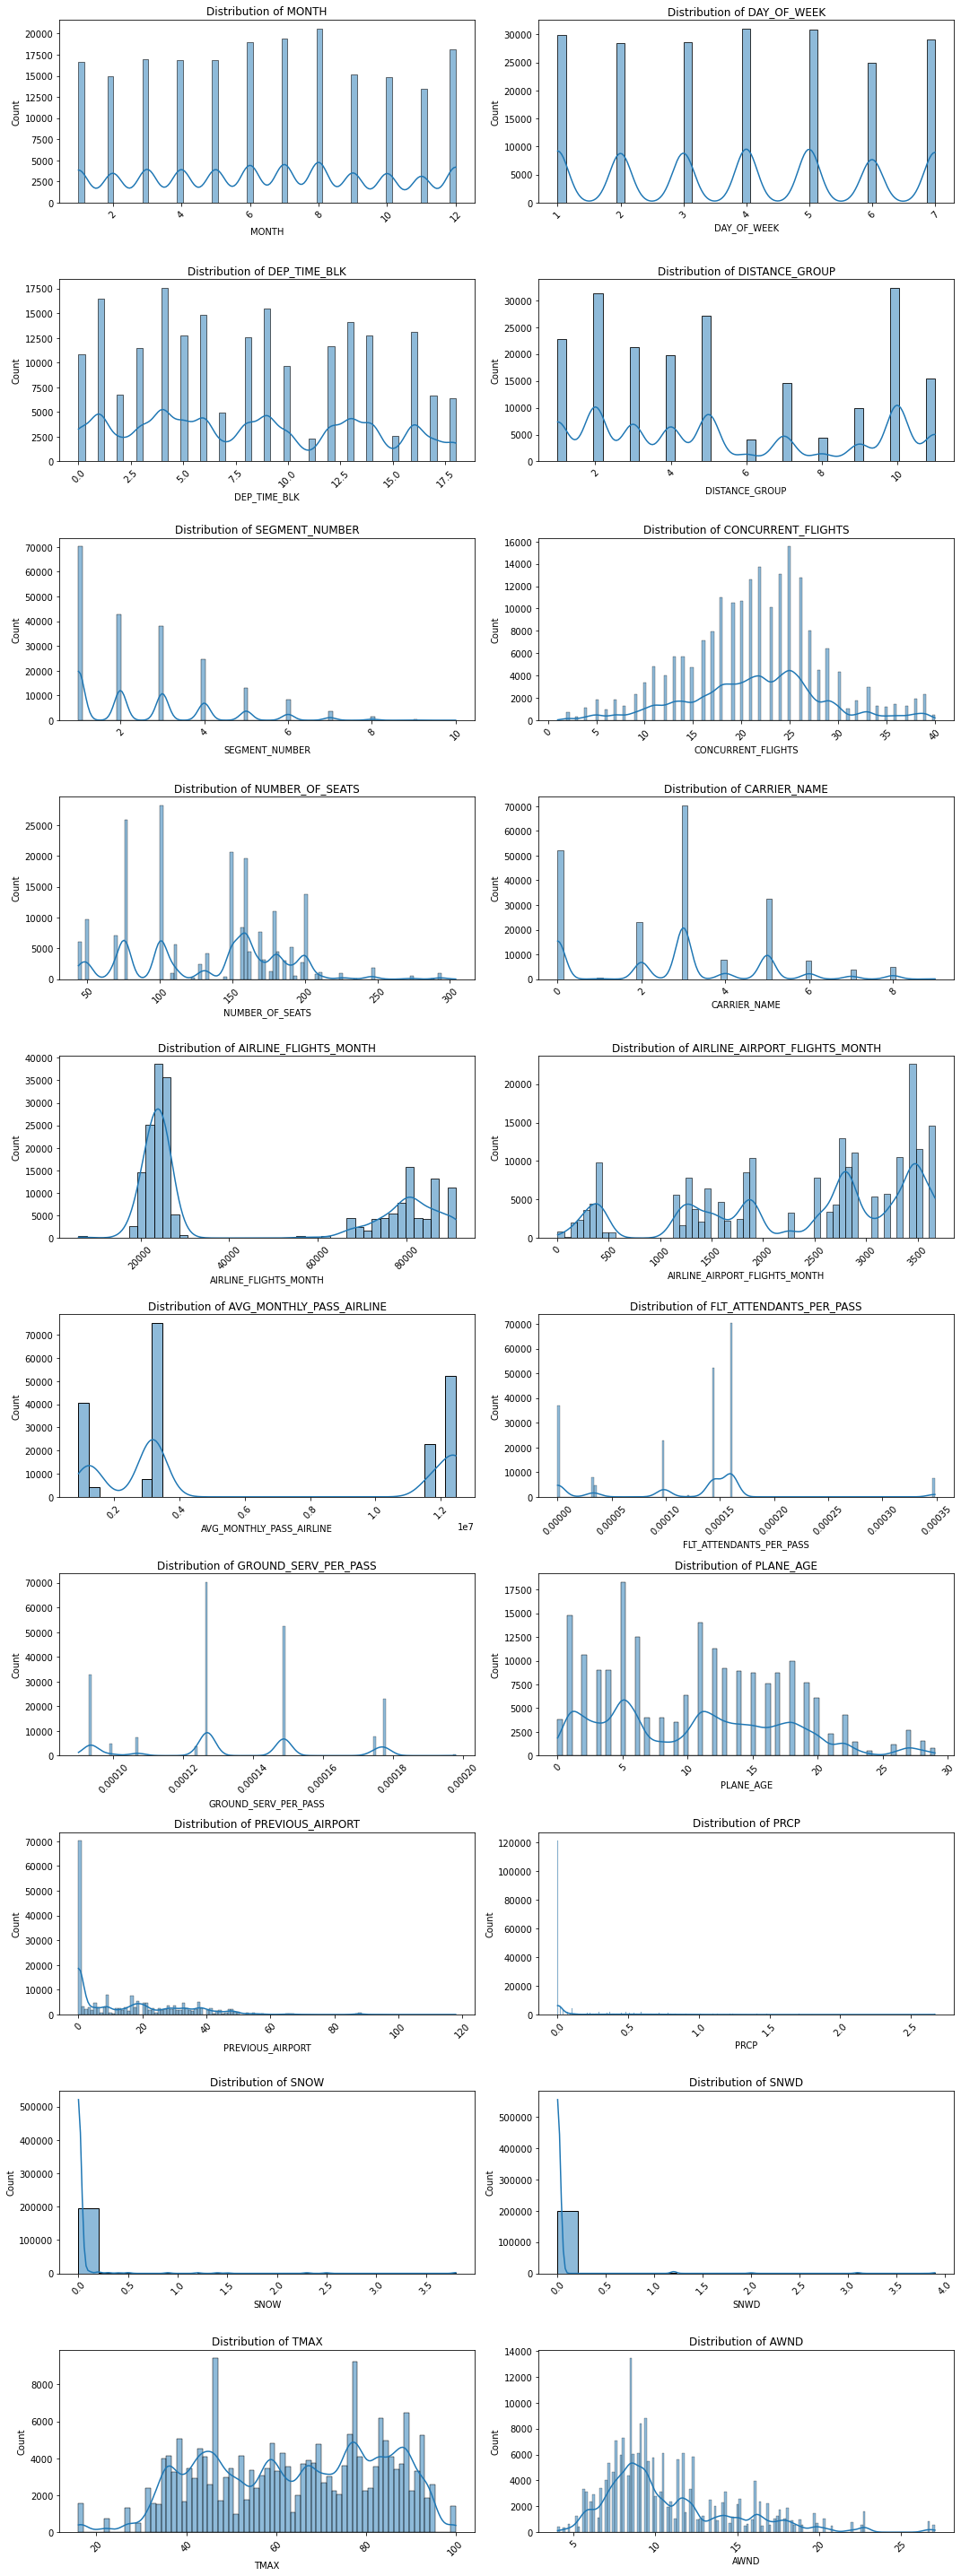

In [38]:
vis_features(X_rose)

In [8]:
X_rose_train, X_rose_test, y_rose_train, y_rose_test = train_test_split(X_rose, y_rose, test_size=0.2, random_state=42, stratify=y_rose)

### SMOTE (Synthetic Minority Oversampling Technique)
SMOTE generates synthetic examples for the minority class by interpolating between existing minority class examples.

In [25]:
from imblearn.over_sampling import SMOTE  
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)


Legend:
0    101446
1    101446
Name: DEP_DEL15, dtype: int64


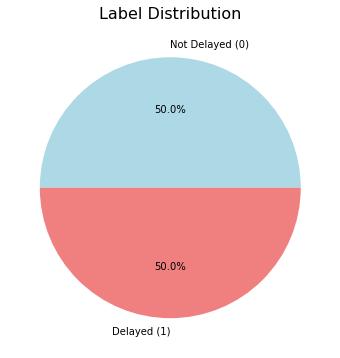

In [10]:
imbalance(y_smote)

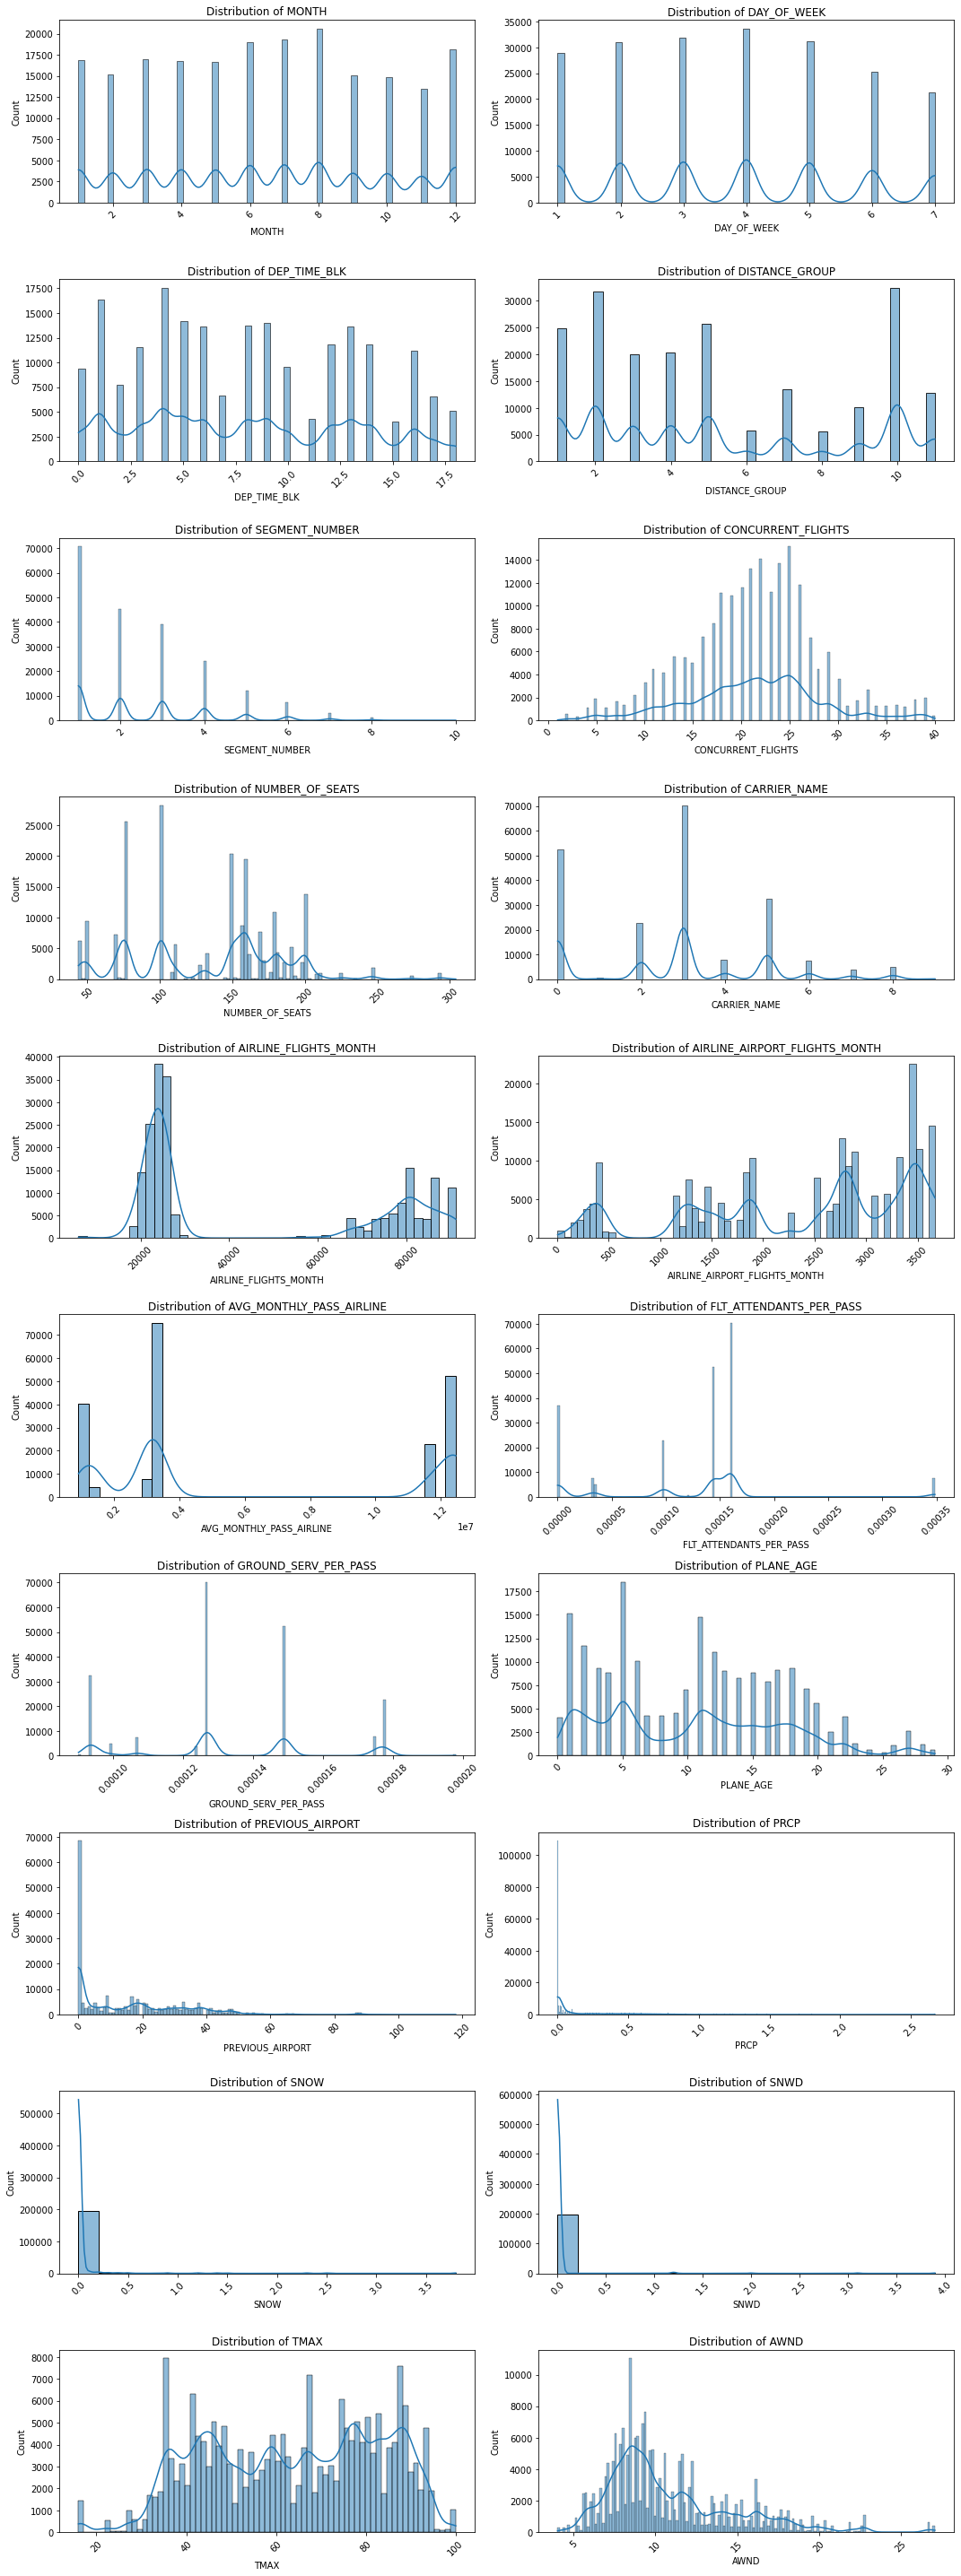

In [22]:
vis_features(X_smote)

In [26]:
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote)

### ADASYN (Adaptive Synthetic Sampling)
ADASYN is an adaptive oversampling method that generates synthetic samples for the minority class. It focuses on the samples that are difficult to classify by assigning higher weights to them.

In [27]:
from imblearn.over_sampling import ADASYN 
adasyn = ADASYN(sampling_strategy='auto', random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)


Legend:
1    109687
0    101446
Name: DEP_DEL15, dtype: int64


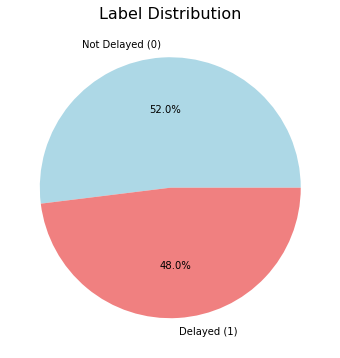

In [25]:
imbalance(y_adasyn)

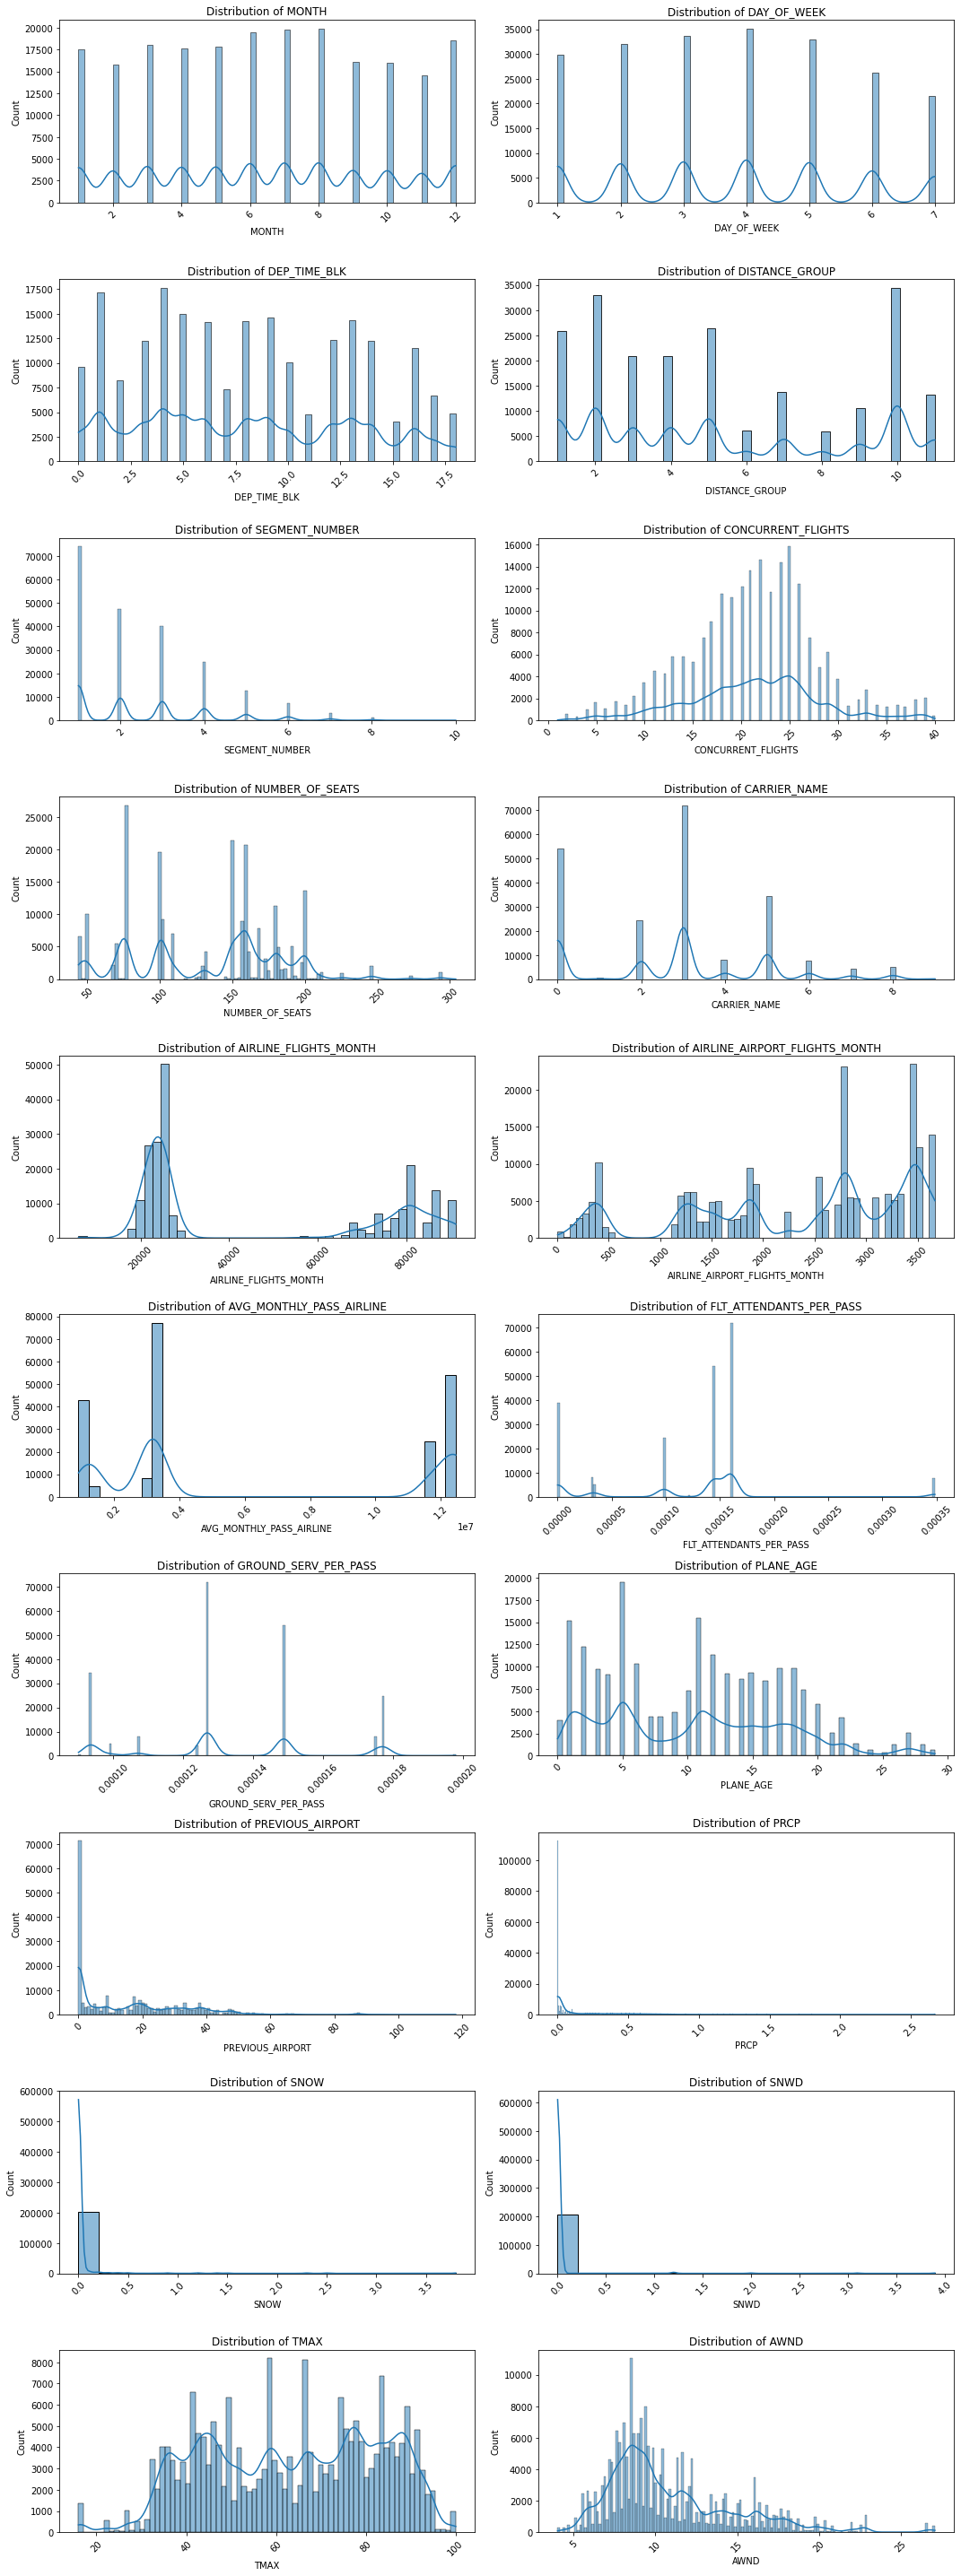

In [26]:
vis_features(X_adasyn)

In [28]:
X_adasyn_train, X_adasyn_test, y_adasyn_train, y_adasyn_test = train_test_split(X_adasyn, y_adasyn, test_size=0.2, random_state=42, stratify=y_adasyn)

## Undersampling Techniques

### Tomek Links
Tomek links are pairs of instances (one from the minority class and one from the majority class) that are closest to each other and of different classes. By Removing the majority class member of these pairs, Tomek Links can improve the class separation.

In [29]:
from imblearn.under_sampling import TomekLinks
tl = TomekLinks(sampling_strategy='auto')
X_tomek, y_tomek = tl.fit_resample(X, y)

Legend:
0    92816
1    23663
Name: DEP_DEL15, dtype: int64


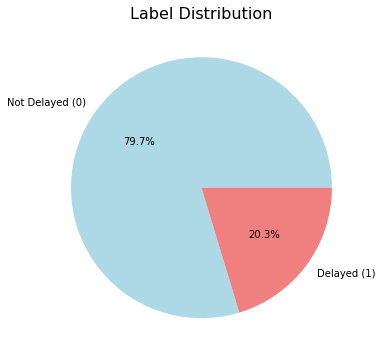

In [29]:
imbalance(y_tomek)

This has not significantly changed the distribution of labels in the data set.

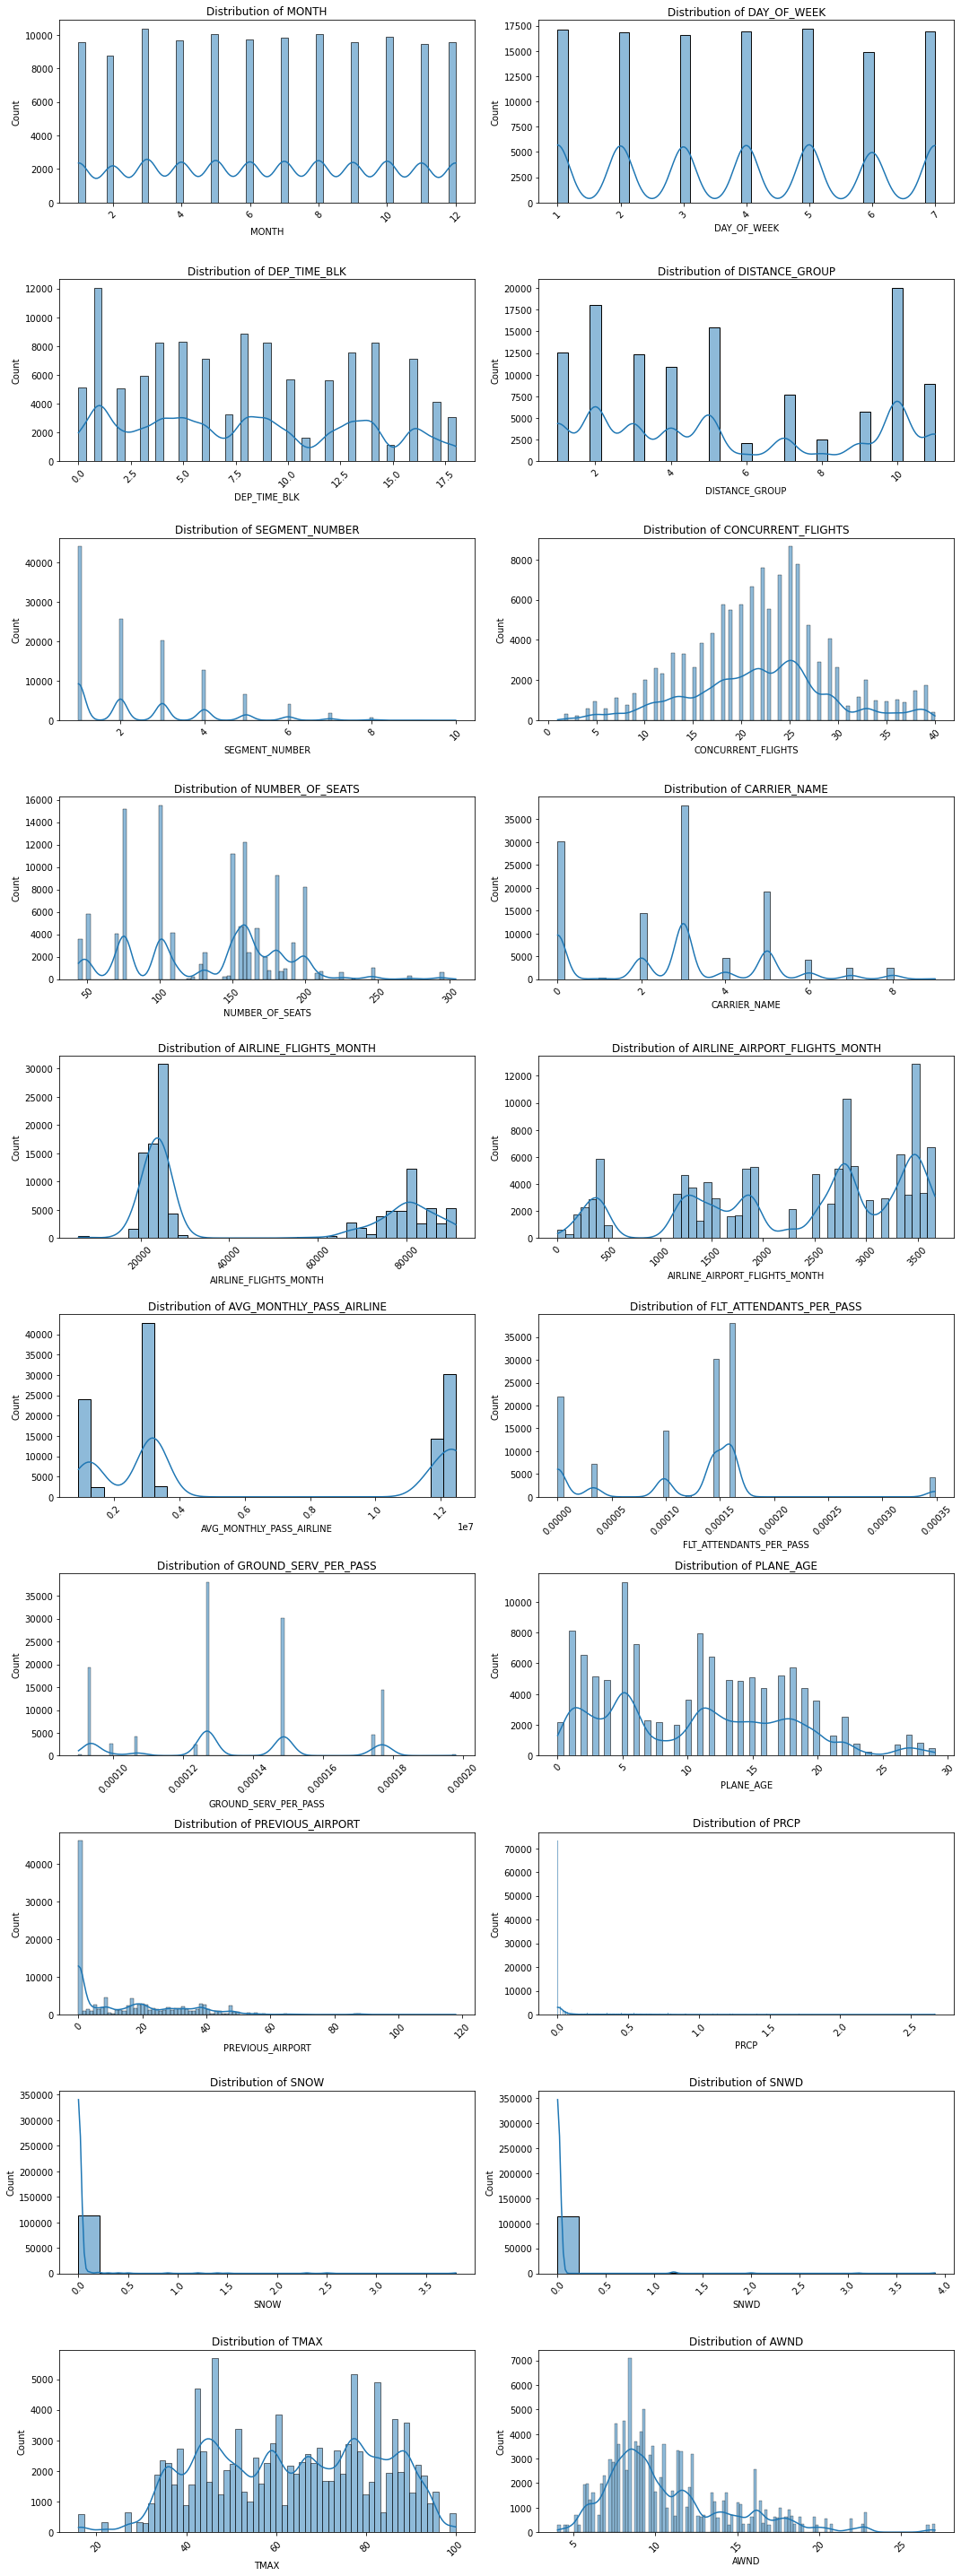

In [30]:
vis_features(X_tomek)

In [30]:
X_tomek_train, X_tomek_test, y_tomek_train, y_tomek_test = train_test_split(X_tomek, y_tomek, test_size=0.2, random_state=42, stratify=y_tomek)

### ENN (Edited Nearest Neighbors)
ENN is an undersampling method that removes majority class samples whose class labels are misclassified by their k-nearest neighbours.

In [31]:
from imblearn.under_sampling import EditedNearestNeighbours
enn = EditedNearestNeighbours(sampling_strategy='auto', n_neighbors=3)
X_enn, y_enn = enn.fit_resample(X, y)

Legend:
0    63743
1    23663
Name: DEP_DEL15, dtype: int64


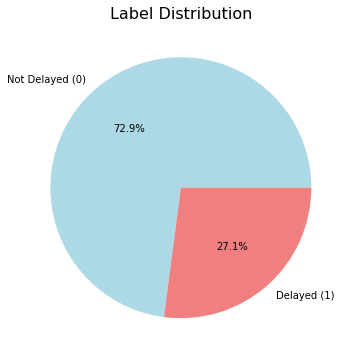

In [33]:
imbalance(y_enn)

This has changed the distribution of labels in the data set more than the Tomek's links method. However, there still remains a significant imbalance in the resampled data.

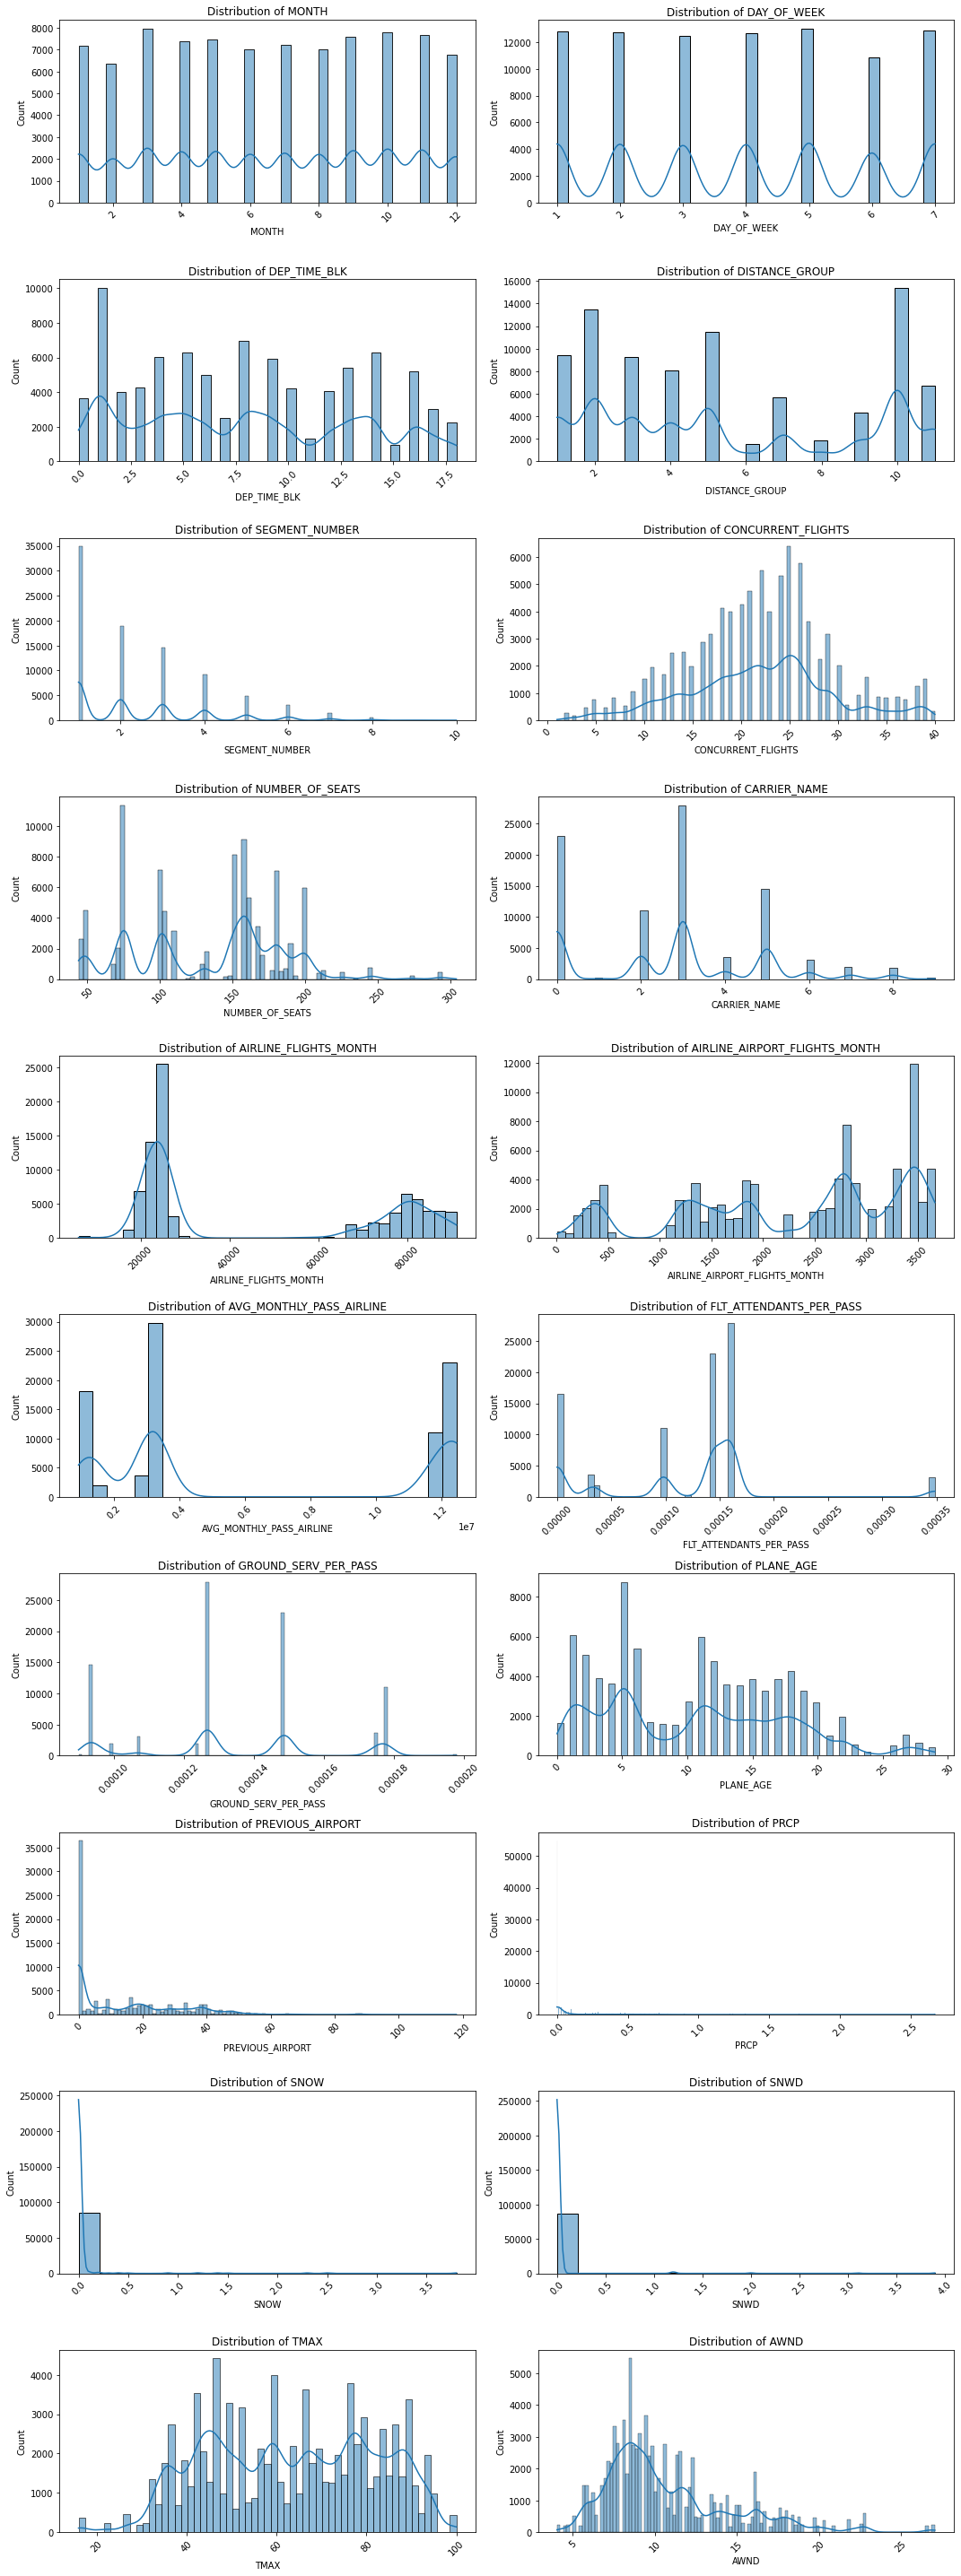

In [34]:
vis_features(X_enn)

In [32]:
X_enn_train, X_enn_test, y_enn_train, y_enn_test = train_test_split(X_enn, y_enn, test_size=0.2, random_state=42, stratify=y_enn)

## Combined Undersampling and Oversampling Techniques


### SMOTE-Tomek Links
MOTE-ENN combines SMOTE oversampling with the Tomek Links undersampling method to improve the quality of synthetic samples and reduce noise.

In [34]:
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(sampling_strategy='auto')
X_smote_tomek, y_smote_tomek = smote_tomek.fit_resample(X, y)

Legend:
0    99368
1    99368
Name: DEP_DEL15, dtype: int64


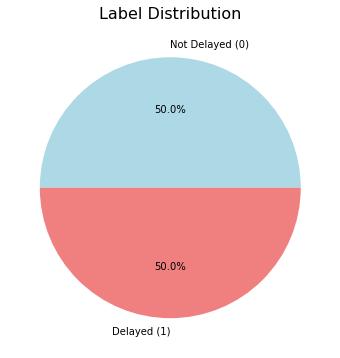

In [37]:
imbalance(y_smote_tomek)

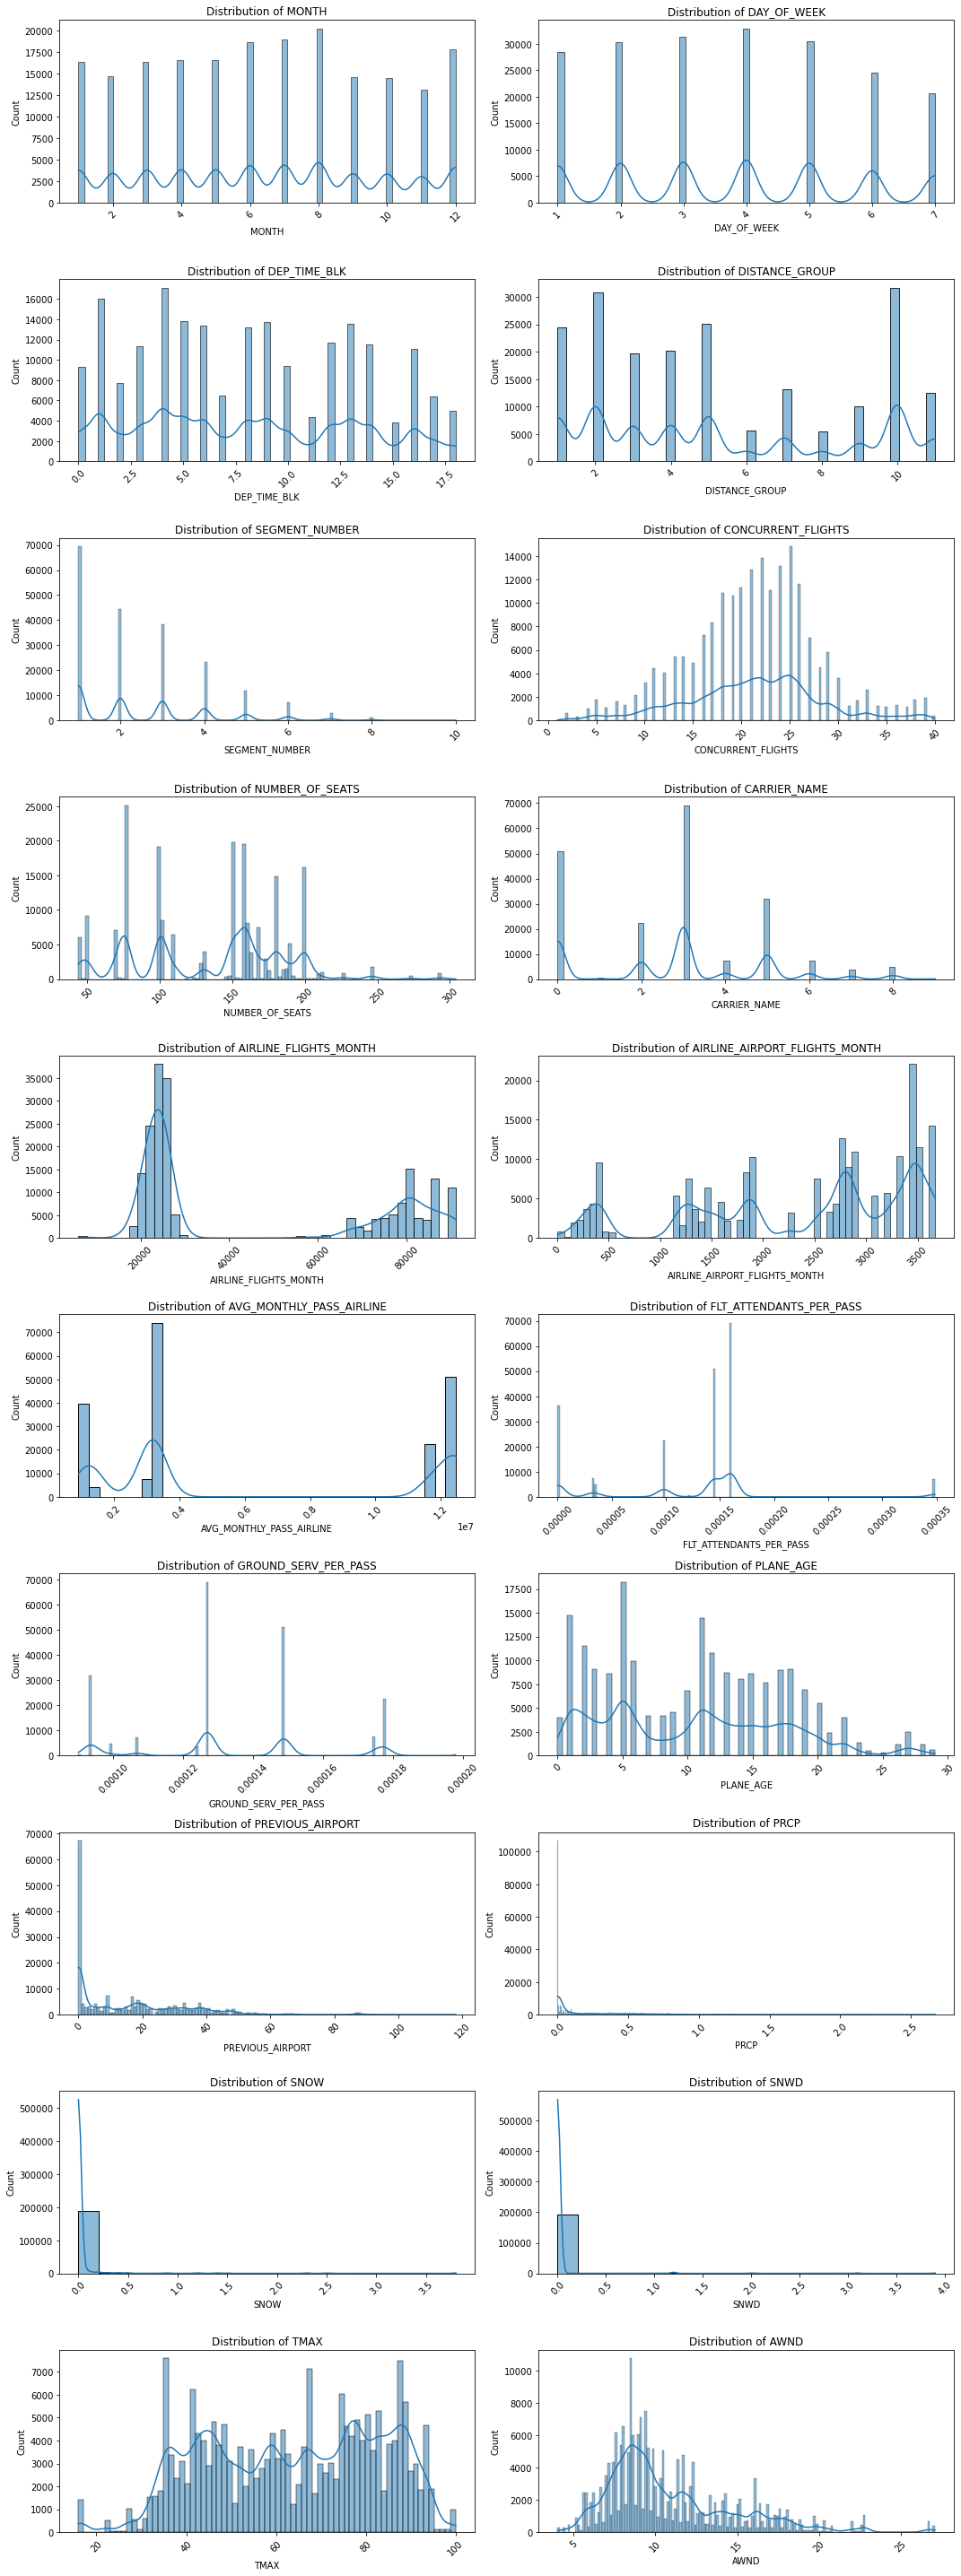

In [38]:
vis_features(X_smote_tomek)

In [35]:
X_smote_tomek_train, X_smote_tomek_test, y_smote_tomek_train, y_smote_tomek_test = train_test_split(X_smote_tomek, y_smote_tomek, test_size=0.2, random_state=42, stratify=y_smote_tomek)

### SMOTE-ENN
MOTE-ENN combines SMOTE oversampling with the ENN undersampling method to improve the quality of synthetic samples and reduce noise.

In [36]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(sampling_strategy='auto', smote=SMOTE(sampling_strategy='auto', random_state=42), enn=EditedNearestNeighbours(sampling_strategy='auto'))
X_smoteenn, y_smoteenn = smote_enn.fit_resample(X, y)

Legend:
0    101446
1     80443
Name: DEP_DEL15, dtype: int64


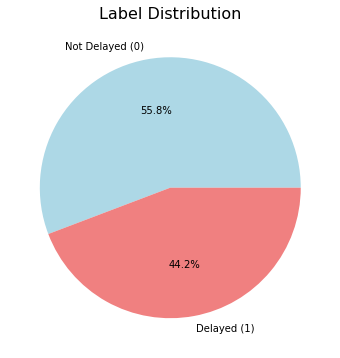

In [41]:
imbalance(y_smoteenn)

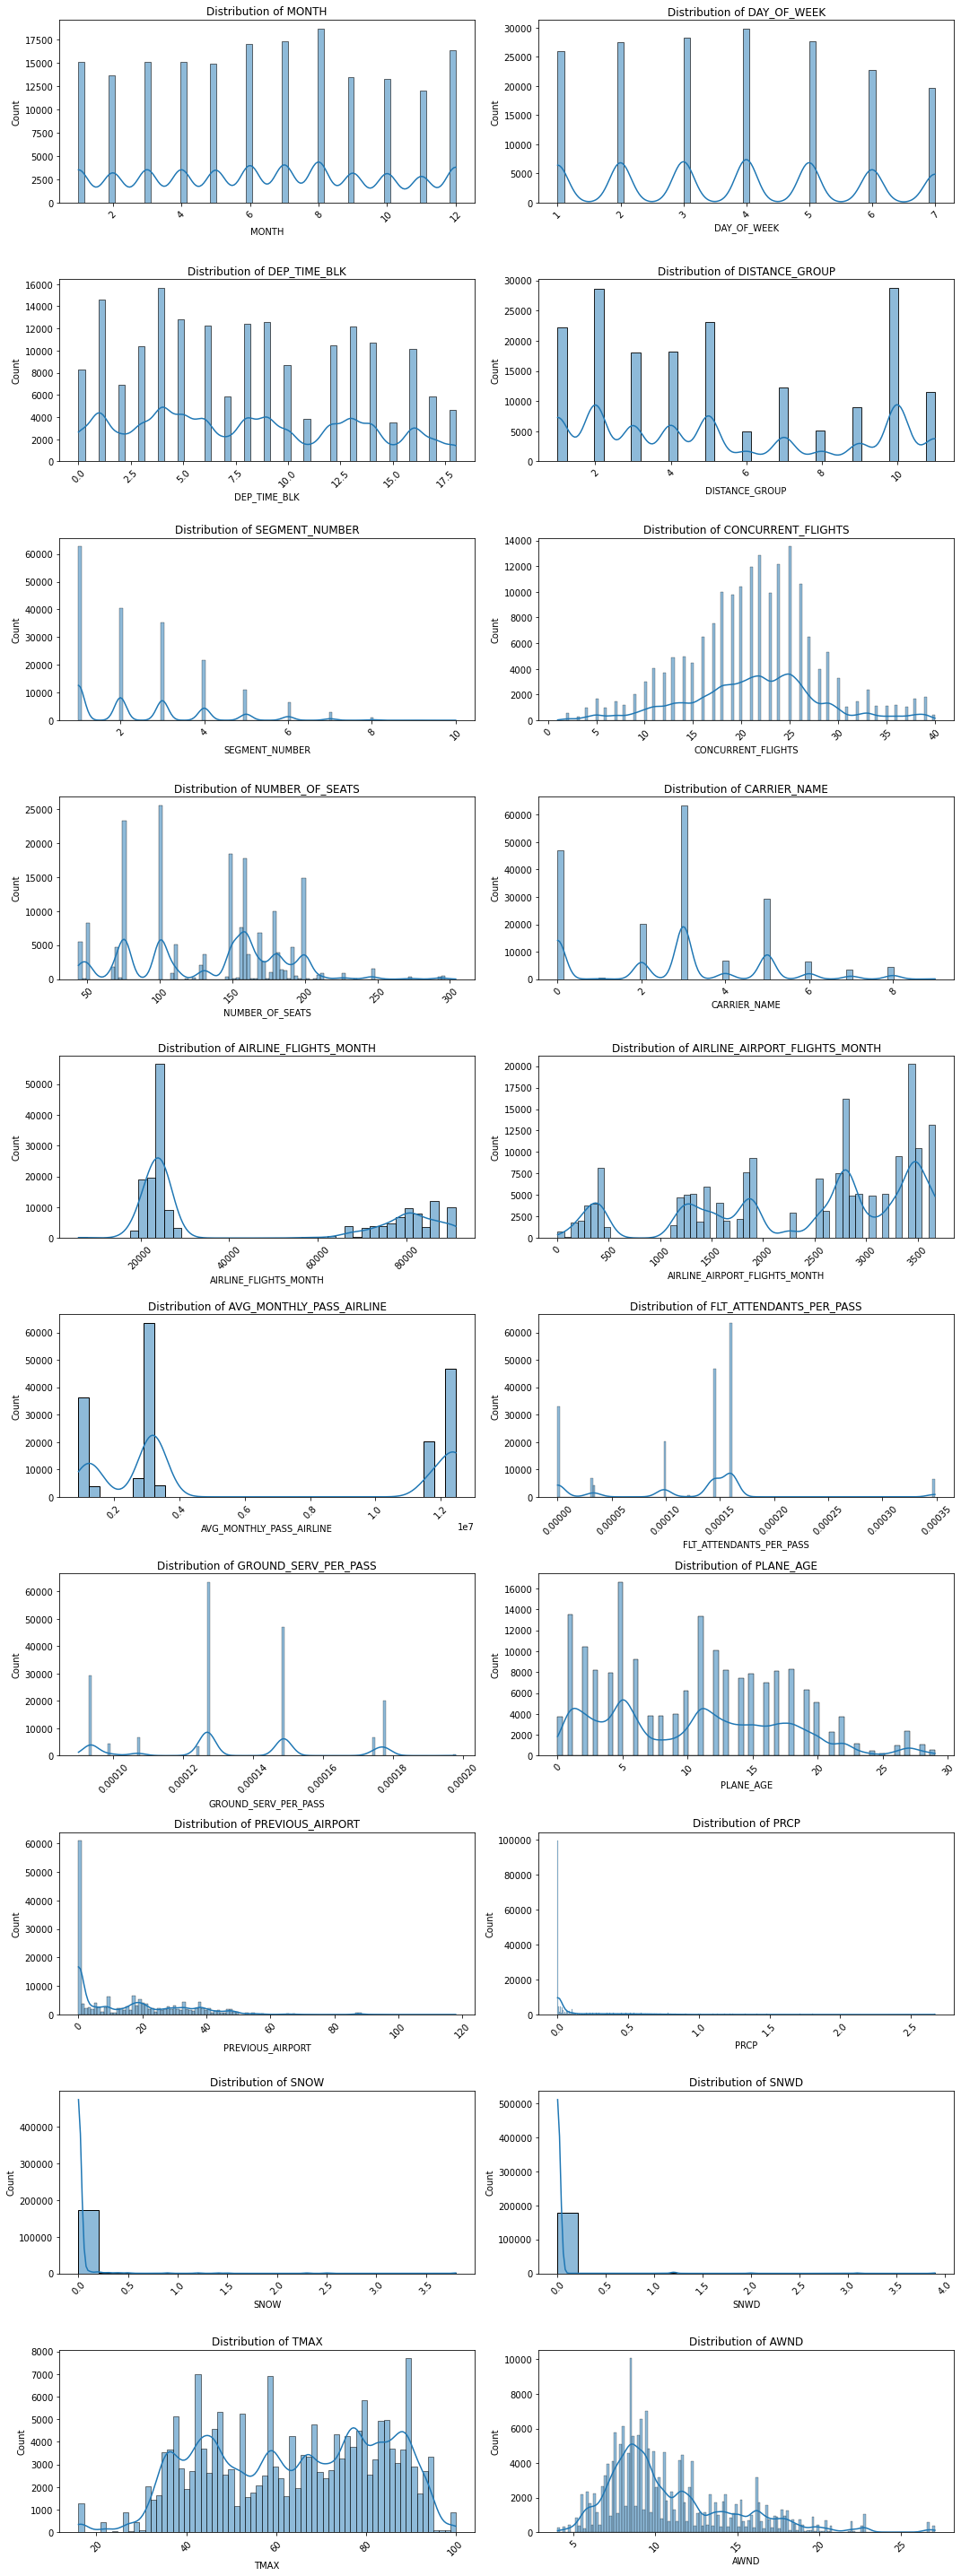

In [42]:
vis_features(X_smoteenn)

In [37]:
X_smoteenn_train, X_smoteenn_test, y_smoteenn_train, y_smoteenn_test = train_test_split(X_smoteenn, y_smoteenn, test_size=0.2, random_state=42, stratify=y_smoteenn)

We now test the performance of the baseline logistic regression model when trained against data sets produced from each technique.

## Logistic Regression (Baseline Model)

Logistic regression is a statistical method used for binary classification. It predicts the probability that an instance belongs to a particular class.

Mathematically, logistic regression uses the logistic function to model the relationship between the independent variables and the probability of the dependent variable being in a particular class.

The logistic function is represented as:
$P(Y=1|X) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_n X_n)}}$

Where:
$P(Y=1|X)$ is the probability that the dependent (target) variable, Y equals 1 given the independent variables.

$X_1, X_2, ..., X_n $ are the independent variables.

$\beta_1, \beta_2, ..., \beta_n $ are the coefficients.

The model estimates the coefficients that best fit the data, typically using techniques like maximum likelihood estimation.

If the calculated probability is above a certain threshold (typically 0.5), the instance is assigned to the positive class (class 1), otherwise to the negative class (class 0). 


To implement the logistic regression, we use a pipeline to automate every stage in the process. We perform preprocessing using StandardScaler for numerical features which ensures that all features contribute equally to the model fitting. We select the best features using SelectKBest with the ANOVA F-statistic.
We apply logistic regression with various hyperparameters. We then use GridSearchCV to search for the best hyperparameters based on ROC AUC as the evaluation metric. [2]

In [11]:
# Define preprocessing steps
preprocessing = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X.columns)],
    remainder='passthrough'
)

# Create pipeline
pipeline = Pipeline([
    ('preprocess', preprocessing),
    ('select_features', SelectKBest(score_func=f_classif, k='all')),
    ('logreg', LogisticRegression(max_iter=1000, penalty='l2', solver='liblinear'))
])


#### Hyperparameter search grid

Regularisation is a way to avoid overfitting by penalising high-valued regression coefficients

The 'logreg__C' parameter is the regularisation strength in logistic regression that determines the inverse of regularisation strength. The values are tested from 0.001 to 1000. 

The 'logreg__penalty' parameter specifies the type of penalty used in logistic regression. It tests both L1 regularisation, which adds a penalty equal to the absolute value of the magnitude of coefficients, and L2 (Ridge) regularisation, which adds a penalty equal to the square of the magnitude of coefficients.

The 'select_features__k' parameter determines the number of features to select using the SelectKBest method. The options are to test selecting 10 features, 20 features. [3]

In [12]:
# Define hyperparameter grid for GridSearchCV
param_grid = {
    'logreg__C': np.logspace(-3, 3, 7),
    'logreg__penalty': ['l1', 'l2'],
    'select_features__k': [10, 20],
}


### (Imbalanced) X Data

In [17]:
# Create GridSearchCV instance
grid_search = GridSearchCV(pipeline, param_grid, cv=StratifiedKFold(n_splits=5), scoring='roc_auc', n_jobs=-1, verbose=1)

# Fit the model and perform hyperparameter tuning
grid_search.fit(X_train, y_train)  


Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['MONTH', 'DAY_OF_WEEK', 'DEP_TIME_BLK', 'DISTANCE_GROUP',
       'SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS',
       'CARRIER_NAME', 'AIRLINE_FLIGHTS_MONTH...
       'PREVIOUS_AIRPORT', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND'],
      dtype='object'))])),
                                       ('select_features',
                                        SelectKBest(k='all')),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logreg__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'logreg__penalty': ['l1', 'l2'],
                         'select_features__k': [10, 20]},
             scoring='roc_auc', verbose=1)

In [18]:
# Get the best estimator
best_pipeline = grid_search.best_estimator_

# Make predictions
y_pred = best_pipeline.predict(X_test)  


In [19]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the results
print("Best Hyperparameters:", grid_search.best_params_)
print("Accuracy:", accuracy)
print("ROC AUC:", roc_auc)
print("Classification Report:\n", report)

Best Hyperparameters: {'logreg__C': 1.0, 'logreg__penalty': 'l1', 'select_features__k': 20}
Accuracy: 0.8098073695148269
ROC AUC: 0.5030041393101461
Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.89     20289
           1       0.39      0.01      0.02      4733

    accuracy                           0.81     25022
   macro avg       0.60      0.50      0.46     25022
weighted avg       0.73      0.81      0.73     25022



This results demonstrates how using only the precision score as a measure of model performance can be deceptive when using imbalanced data. A score of 0.810 gives the impression that the model is performing very well, however when the ROC AUC score and the classification report are taken into account, it is evident that the model is not distinguishing between the two classes well.

### ROSE (Random Over-Sampling Examples)

In [20]:
grid_search_rose = GridSearchCV(pipeline, param_grid, cv=StratifiedKFold(n_splits=5), scoring='roc_auc', n_jobs=-1, verbose=1)

grid_search_rose.fit(X_rose_train, y_rose_train)


Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['MONTH', 'DAY_OF_WEEK', 'DEP_TIME_BLK', 'DISTANCE_GROUP',
       'SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS',
       'CARRIER_NAME', 'AIRLINE_FLIGHTS_MONTH...
       'PREVIOUS_AIRPORT', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND'],
      dtype='object'))])),
                                       ('select_features',
                                        SelectKBest(k='all')),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logreg__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'logreg__penalty': ['l1', 'l2'],
                         'select_features__k': [10, 20]},
             scoring='roc_auc', verbose=1)

In [ ]:
# Get the best estimator
best_pipeline_rose = grid_search_rose.best_estimator_

# Make predictions
y_rose_pred = best_pipeline_rose.predict(X_rose_test)  


In [22]:
# Evaluate the model
accuracy = accuracy_score(y_rose_test, y_rose_pred)
roc_auc = roc_auc_score(y_rose_test, y_rose_pred)
report = classification_report(y_rose_test, y_rose_pred)

# Print the results
print("Best Hyperparameters:", grid_search_rose.best_params_)
print("Accuracy:", accuracy)
print("ROC AUC:", roc_auc)
print("Classification Report:\n", report)

Best Hyperparameters: {'logreg__C': 0.1, 'logreg__penalty': 'l2', 'select_features__k': 20}
Accuracy: 0.5992262007442273
ROC AUC: 0.5992255792414689
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.62      0.61     20290
           1       0.60      0.57      0.59     20289

    accuracy                           0.60     40579
   macro avg       0.60      0.60      0.60     40579
weighted avg       0.60      0.60      0.60     40579



### SMOTE

In [38]:
grid_search_smote = GridSearchCV(pipeline, param_grid, cv=StratifiedKFold(n_splits=5), scoring='roc_auc', n_jobs=-1, verbose=1)

grid_search_smote.fit(X_smote_train, y_smote_train)


Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['MONTH', 'DAY_OF_WEEK', 'DEP_TIME_BLK', 'DISTANCE_GROUP',
       'SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS',
       'CARRIER_NAME', 'AIRLINE_FLIGHTS_MONTH...
       'PREVIOUS_AIRPORT', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND'],
      dtype='object'))])),
                                       ('select_features',
                                        SelectKBest(k='all')),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logreg__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'logreg__penalty': ['l1', 'l2'],
                         'select_features__k': [10, 20]},
             scoring='roc_auc', verbose=1)

In [39]:
# Get the best estimator
best_pipeline_smote = grid_search_smote.best_estimator_

# Make predictions
y_smote_pred = best_pipeline_smote.predict(X_smote_test) 


In [40]:
# Evaluate the model
accuracy = accuracy_score(y_smote_test, y_smote_pred)
roc_auc = roc_auc_score(y_smote_test, y_smote_pred)
report = classification_report(y_smote_test, y_smote_pred)

# Print the results
print("Best Hyperparameters:", grid_search_smote.best_params_)
print("Accuracy:", accuracy)
print("ROC AUC:", roc_auc)
print("Classification Report:\n", report)

Best Hyperparameters: {'logreg__C': 0.1, 'logreg__penalty': 'l2', 'select_features__k': 20}
Accuracy: 0.6062741812267429
ROC AUC: 0.6062737904990969
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.62      0.61     20290
           1       0.61      0.59      0.60     20289

    accuracy                           0.61     40579
   macro avg       0.61      0.61      0.61     40579
weighted avg       0.61      0.61      0.61     40579



### ADASYNC

In [41]:
grid_search_adasyn = GridSearchCV(pipeline, param_grid, cv=StratifiedKFold(n_splits=5), scoring='roc_auc', n_jobs=-1, verbose=1)


grid_search_adasyn.fit(X_adasyn_train, y_adasyn_train)


Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['MONTH', 'DAY_OF_WEEK', 'DEP_TIME_BLK', 'DISTANCE_GROUP',
       'SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS',
       'CARRIER_NAME', 'AIRLINE_FLIGHTS_MONTH...
       'PREVIOUS_AIRPORT', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND'],
      dtype='object'))])),
                                       ('select_features',
                                        SelectKBest(k='all')),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logreg__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'logreg__penalty': ['l1', 'l2'],
                         'select_features__k': [10, 20]},
             scoring='roc_auc', verbose=1)

In [42]:
# Get the best estimator
best_pipeline_adasyn = grid_search_adasyn.best_estimator_

# Make predictions
y_adasyn_pred = best_pipeline_adasyn.predict(X_adasyn_test)  


In [43]:
# Evaluate the model
accuracy = accuracy_score(y_adasyn_test, y_adasyn_pred)
roc_auc = roc_auc_score(y_adasyn_test, y_adasyn_pred)
report = classification_report(y_adasyn_test, y_adasyn_pred)

# Print the results
print("Best Hyperparameters:", grid_search_adasyn.best_params_)
print("Accuracy:", accuracy)
print("ROC AUC:", roc_auc)
print("Classification Report:\n", report)

Best Hyperparameters: {'logreg__C': 0.1, 'logreg__penalty': 'l1', 'select_features__k': 20}
Accuracy: 0.599024320932105
ROC AUC: 0.5969837172485625
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.54      0.57     20289
           1       0.61      0.65      0.63     21938

    accuracy                           0.60     42227
   macro avg       0.60      0.60      0.60     42227
weighted avg       0.60      0.60      0.60     42227



### Tomek Link

In [44]:
grid_search_tomek = GridSearchCV(pipeline, param_grid, cv=StratifiedKFold(n_splits=5), scoring='roc_auc', n_jobs=-1, verbose=1)


grid_search_tomek.fit(X_tomek_train, y_tomek_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['MONTH', 'DAY_OF_WEEK', 'DEP_TIME_BLK', 'DISTANCE_GROUP',
       'SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS',
       'CARRIER_NAME', 'AIRLINE_FLIGHTS_MONTH...
       'PREVIOUS_AIRPORT', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND'],
      dtype='object'))])),
                                       ('select_features',
                                        SelectKBest(k='all')),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logreg__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'logreg__penalty': ['l1', 'l2'],
                         'select_features__k': [10, 20]},
             scoring='roc_auc', verbose=1)

In [45]:
# Get the best estimator
best_pipeline_tomek = grid_search_tomek.best_estimator_

# Make predictions
y_tomek_pred = best_pipeline_tomek.predict(X_tomek_test)  


In [46]:
# Evaluate the model
accuracy = accuracy_score(y_tomek_test, y_tomek_pred)
roc_auc = roc_auc_score(y_tomek_test, y_tomek_pred)
report = classification_report(y_tomek_test, y_tomek_pred)

# Print the results
print("Best Hyperparameters:", grid_search_tomek.best_params_)
print("Accuracy:", accuracy)
print("ROC AUC:", roc_auc)
print("Classification Report:\n", report)

Best Hyperparameters: {'logreg__C': 0.1, 'logreg__penalty': 'l2', 'select_features__k': 20}
Accuracy: 0.7965315934065934
ROC AUC: 0.5063440459877617
Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89     18563
           1       0.48      0.02      0.03      4733

    accuracy                           0.80     23296
   macro avg       0.64      0.51      0.46     23296
weighted avg       0.73      0.80      0.71     23296



### ENN

In [47]:
grid_search_enn = GridSearchCV(pipeline, param_grid, cv=StratifiedKFold(n_splits=5), scoring='roc_auc', n_jobs=-1, verbose=1)

grid_search_enn.fit(X_enn_train, y_enn_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['MONTH', 'DAY_OF_WEEK', 'DEP_TIME_BLK', 'DISTANCE_GROUP',
       'SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS',
       'CARRIER_NAME', 'AIRLINE_FLIGHTS_MONTH...
       'PREVIOUS_AIRPORT', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND'],
      dtype='object'))])),
                                       ('select_features',
                                        SelectKBest(k='all')),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logreg__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'logreg__penalty': ['l1', 'l2'],
                         'select_features__k': [10, 20]},
             scoring='roc_auc', verbose=1)

In [48]:
# Get the best estimator
best_pipeline_enn = grid_search_enn.best_estimator_

# Make predictions
y_enn_pred = best_pipeline_enn.predict(X_enn_test) 


In [49]:
# Evaluate the model
accuracy = accuracy_score(y_enn_test, y_enn_pred)
roc_auc = roc_auc_score(y_enn_test, y_enn_pred)
report = classification_report(y_enn_test, y_enn_pred)

# Print the results
print("Best Hyperparameters:", grid_search_enn.best_params_)
print("Accuracy:", accuracy)
print("ROC AUC:", roc_auc)
print("Classification Report:\n", report)

Best Hyperparameters: {'logreg__C': 1.0, 'logreg__penalty': 'l2', 'select_features__k': 20}
Accuracy: 0.7341837318384624
ROC AUC: 0.5339935768732569
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.97      0.84     12749
           1       0.55      0.10      0.17      4733

    accuracy                           0.73     17482
   macro avg       0.65      0.53      0.50     17482
weighted avg       0.69      0.73      0.66     17482



### SMOTE-Tomek Links

In [50]:
grid_search_smote_tomek = GridSearchCV(pipeline, param_grid, cv=StratifiedKFold(n_splits=5), scoring='roc_auc', n_jobs=-1, verbose=1)

grid_search_smote_tomek.fit(X_smote_tomek_train, y_smote_tomek_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['MONTH', 'DAY_OF_WEEK', 'DEP_TIME_BLK', 'DISTANCE_GROUP',
       'SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS',
       'CARRIER_NAME', 'AIRLINE_FLIGHTS_MONTH...
       'PREVIOUS_AIRPORT', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND'],
      dtype='object'))])),
                                       ('select_features',
                                        SelectKBest(k='all')),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logreg__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'logreg__penalty': ['l1', 'l2'],
                         'select_features__k': [10, 20]},
             scoring='roc_auc', verbose=1)

In [51]:

# Get the best estimator
best_pipeline_smote_tomek = grid_search_smote_tomek.best_estimator_

# Make predictions
y_smote_tomek_pred = best_pipeline_smote_tomek.predict(X_smote_tomek_test) 


In [52]:
# Evaluate the model
accuracy = accuracy_score(y_smote_tomek_test, y_smote_tomek_pred)
roc_auc = roc_auc_score(y_smote_tomek_test, y_smote_tomek_pred)
report = classification_report(y_smote_tomek_test, y_smote_tomek_pred)

# Print the results
print("Best Hyperparameters:", grid_search_smote_tomek.best_params_)
print("Accuracy:", accuracy)
print("ROC AUC:", roc_auc)
print("Classification Report:\n", report)

Best Hyperparameters: {'logreg__C': 1.0, 'logreg__penalty': 'l2', 'select_features__k': 20}
Accuracy: 0.6080924564407292
ROC AUC: 0.6080924564407293
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.62      0.61     19858
           1       0.61      0.59      0.60     19858

    accuracy                           0.61     39716
   macro avg       0.61      0.61      0.61     39716
weighted avg       0.61      0.61      0.61     39716



### SMOTE-ENN

In [53]:
grid_search_smoteenn = GridSearchCV(pipeline, param_grid, cv=StratifiedKFold(n_splits=5), scoring='roc_auc', n_jobs=-1, verbose=1)


grid_search_smoteenn.fit(X_smoteenn_train, y_smoteenn_train)


Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['MONTH', 'DAY_OF_WEEK', 'DEP_TIME_BLK', 'DISTANCE_GROUP',
       'SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS',
       'CARRIER_NAME', 'AIRLINE_FLIGHTS_MONTH...
       'PREVIOUS_AIRPORT', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND'],
      dtype='object'))])),
                                       ('select_features',
                                        SelectKBest(k='all')),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logreg__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'logreg__penalty': ['l1', 'l2'],
                         'select_features__k': [10, 20]},
             scoring='roc_auc', verbose=1)

In [54]:
# Get the best estimator
best_pipeline_smoteenn = grid_search_smoteenn.best_estimator_

# Make predictions
y_smoteenn_pred = best_pipeline_smoteenn.predict(X_smoteenn_test)  


In [55]:
# Evaluate the model
accuracy = accuracy_score(y_smoteenn_test, y_smoteenn_pred)
roc_auc = roc_auc_score(y_smoteenn_test, y_smoteenn_pred)
report = classification_report(y_smoteenn_test, y_smoteenn_pred)

# Print the results
print("Best Hyperparameters:", grid_search_smoteenn.best_params_)
print("Accuracy:", accuracy)
print("ROC AUC:", roc_auc)
print("Classification Report:\n", report)

Best Hyperparameters: {'logreg__C': 1.0, 'logreg__penalty': 'l1', 'select_features__k': 20}
Accuracy: 0.6180658639837264
ROC AUC: 0.5980194983532152
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.77      0.69     20289
           1       0.60      0.42      0.50     16089

    accuracy                           0.62     36378
   macro avg       0.61      0.60      0.59     36378
weighted avg       0.61      0.62      0.61     36378



### Discussion

The best results came from the SMOTE data. The logistic regression model trained and tested on this data had a ROC AUC score of 0.606, which represents an increase of 20.5% from the imbalanced data which had a ROC AUC score of 0.503.

SMOTE (Synthetic Minority Oversampling Technique) is an oversampling technique used to generate synthetic samples for the minority class. For each minority class sample, SMOTE selects a certain number of its nearest neighbours and generates synthetic samples by interpolating between the chosen instance and its neighbours. By introducing new instances, SMOTE may have enhanced the model's capability to capture intricate patterns, resulting in a more robust and generalised model.

Furthermore, we trained and tested on the imbalanced data using the hyperparameters selected using this method. Although, the ROC AUC score is not as high as when trained and tested on the SMOTE data, it is however higher than the original model.

In [56]:
y_pred2 = best_pipeline_smote.predict(X_test) 

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred2)
roc_auc = roc_auc_score(y_test, y_pred2)
report = classification_report(y_test, y_pred2)

# Print the results
print("Best Hyperparameters:", grid_search_smote.best_params_)
print("Accuracy:", accuracy)
print("ROC AUC:", roc_auc)
print("Classification Report:\n", report)



Best Hyperparameters: {'logreg__C': 0.1, 'logreg__penalty': 'l2', 'select_features__k': 20}
Accuracy: 0.6091039884901287
ROC AUC: 0.5877296653052801
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.62      0.72     20289
           1       0.25      0.55      0.35      4733

    accuracy                           0.61     25022
   macro avg       0.56      0.59      0.53     25022
weighted avg       0.74      0.61      0.65     25022



Having tested each of the different class imbalance techniques using the baseline logistic regression model, we have found that the best performance came from the SMOTE method. Therefore, we will train each of our models on both the imbalanced data and the SMOTE data.

In [57]:
# Export X_train and X_test
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)  

y_train_df = pd.DataFrame(y_train)
y_test_df = pd.DataFrame(y_test)

y_train_df.to_csv('y_train.csv', index=False)
y_test_df.to_csv('y_test.csv', index=False)


In [58]:
# Export X_adasyn_train and X_adasyn_test
X_smote_train.to_csv('X_smote_train.csv', index=False)  
X_smote_test.to_csv('X_smote_test.csv', index=False)  

y_smote_train_df = pd.DataFrame(y_smote_train)
y_smote_test_df = pd.DataFrame(y_smote_test)

y_smote_train_df.to_csv('y_smote_train.csv', index=False)
y_smote_test_df.to_csv('y_smote_test.csv', index=False)

In [59]:
# Export predictions for model performance comparison

# Convert to Pandas data frames
y_pred_df = pd.DataFrame({'Prediction': y_pred})
y_pred2_df = pd.DataFrame({'Prediction': y_pred2})
#y_smote_pred_df = pd.DataFrame({'Prediction': y_smote_pred})

y_pred_df.to_csv("Logistic_imbalanced_predictions.csv", index=False)
y_pred2_df.to_csv("Logistic_balanced_predictions.csv", index=False)
#y_smote_pred_df.to_csv("Logistic_ypred_smote.csv", index=False)

In [60]:
# Export probabilities for model performance comparison

y_probs = best_pipeline.predict_proba(X_test)[:, 1]
y_probs_smote = best_pipeline_smote.predict_proba(X_test)[:, 1]

y_probs_df = pd.DataFrame({'Probabilities': y_probs})
y_probs_smote_df = pd.DataFrame({'Probabilities': y_probs_smote})

y_probs_df.to_csv("Logistic_imbalanced_probabilities.csv", index=False)
y_probs_smote_df.to_csv("Logistic_balanced_probabilities.csv", index=False)


## References

[1] - Goswami, D.S. (2020). Class Imbalance, SMOTE, Borderline SMOTE, ADASYN. Medium. Available at: https://towardsdatascience.com/class-imbalance-smote-borderline-smote-adasyn-6e36c78d804.

[2] - Stojiljković, M. (n.d). Logistic Regression in Python – Real Python. realpython.com. Available at: https://realpython.com/logistic-regression-python/.

[3] - Stephanie Glen. "Regularization: Simple Definition, L1 & L2 Penalties" From StatisticsHowTo.com: Elementary Statistics for the rest of us! Available at: https://www.statisticshowto.com/regularization/